# 1D VP-System with FVM

## 输入库

In [564]:
import numpy as np
import matplotlib.pyplot as plt
import time

from scipy.interpolate import lagrange
from scipy.special import roots_sh_legendre

n = 3
theta = 0.624*2*np.pi

xMin = 0.44
xMax = 0.57
yMin = 1.35
yMax = 1.85

## 功能函数

2D 拉格朗日插值

In [565]:
def TestF(x,y,xDiv,yDiv):

  x1 = np.cos(theta)*x + np.sin(theta)*y
  y1 = -np.sin(theta)*x + np.cos(theta)*y
  x1x = np.cos(theta)
  x1y = np.sin(theta)
  y1x = -np.sin(theta)
  y1y = np.cos(theta)

  k1 = 0.05*np.pi
  k2 = 0.1*np.pi
  phi1 = k1*(x1+7)
  phi2 = k2*(y1+4)

  f1 = np.cos(phi1)
  f2 = np.sin(phi2)

  f1x1 = -k1*np.sin(phi1)
  f2x1 = 0.0
  f1y1 = 0.0
  f2y1 =  k2*np.cos(phi2)

  if xDiv==1:
    f1x = f1x1*x1x+f1y1*y1x
    f2x = f2x1*x1x+f2y1*y1x
    re = f1*f2x + f1x*f2
  elif yDiv==1:
    f1y = f1x1*x1y+f1y1*y1y
    f2y = f2x1*x1y+f2y1*y1y
    re = f1*f2y + f1y*f2
  else:
    re = f1*f2
  
  return re

In [566]:
def LagF(xNode,yNode,xyRange,zNode,x,y,xDiv,yDiv):
  xMin,yMin,xLen,yLen = xyRange
  x0 = (x-xMin)/xLen
  y0 = (y-yMin)/yLen

  Nx,Ny = zNode.shape
  re = 0.0

  Lix = Li if xDiv==0 else divLi
  Liy = Li if yDiv==0 else divLi

  facX = 1/xLen if xDiv==1 else 1
  facY = 1/yLen if yDiv==1 else 1

  for i in range(0,Nx):
    for j in range(0,Ny):
      re += zNode[i,j]*Lix(xNode[:,0],i,x0)*Liy(yNode[0,:],j,y0)
  return re*facX*facY


def Li_unit(x0,x1,x):
  return (x-x1)/(x0-x1)


def Li(xNode,i,x):
  N = xNode.shape[0]
  re = 1.0
  for j in range(0,N):
    if j != i:
      re *= Li_unit(xNode[i],xNode[j],x)
  return re

def divLi(xNode,i,x):
  err = 1e-10
  N = xNode.shape[0]
  re = 0.0
  for j in range(0,N):
    if j != i:
      re += 1.0/((x-xNode[j]) + err)
  re *= Li(xNode,i,x)
  return re

In [567]:
def LBF(Node):
  N = Node.shape[0]
  LBFpoly = [np.poly1d([1]) for _ in range(N)]
  for i in range(N):
    for j in range(N):
      if i != j:
        LBFpoly[i] *= Li_unit_poly(Node[i],Node[j])
  return LBFpoly


def Li_unit_poly(x0,x1):
  return np.poly1d([1/(x0-x1),x1/(x1-x0)])


def LagF2(Xpolys,Ypolys,xyRange,zNode,x,y):
  xMin,yMin,xLen,yLen = xyRange
  x0 = (x-xMin)/xLen
  y0 = (y-yMin)/yLen
  xVals = np.array([poly(x0) for poly in Xpolys])
  yVals = np.array([poly(y0) for poly in Ypolys])
  re = 0.0
  for i in range(0,xVals.shape[0]):
    for j in range(0,yVals.shape[0]):
      re += xVals[i]*yVals[j]*zNode[i,j]
  return re


#def lagrange(xNode, yNode):
#    """Return the Lagrange polynomial for the given nodes."""
#    n = len(yNode)
#    if n == 1:
#        return lambda x: yNode[0]
#    else:
#        def lagrange(x):
#            result = 0
#            for j in range(n):
#                v = yNode[j]
#                for k in range(n):

In [568]:
nodes, weights = roots_sh_legendre(n)

In [569]:
xLen = xMax - xMin
yLen = yMax - yMin
xyRange = [xMin,yMin,xLen,yLen]

x = np.linspace(xMin,xMax,100).reshape(-1, 1)
y = np.linspace(yMin,yMax,100).reshape( 1,-1)

In [570]:
xL = xL0*xLen + xMin
yL = yL0*yLen + yMin
zL = TestF(xL,yL,0,0)

In [571]:
z0 = TestF(x,y,0,0)
zx0 = TestF(x,y,1,0)
zy0 = TestF(x,y,0,1)

In [572]:
xL0 = nodes.reshape(-1, 1)
yL0 = nodes.reshape( 1,-1)
zL0 = TestF(xL,yL,0,0)

z1 = LagF(xL0,yL0,xyRange,zL0,x,y,0,0)
zx1 = LagF(xL0,yL0,xyRange,zL0,x,y,1,0)
zy1 = LagF(xL0,yL0,xyRange,zL0,x,y,0,1)


In [573]:
xL0Poly = LBF(nodes)
yL0Poly = LBF(nodes)
dxL0Poly = [poly.deriv()/xLen for poly in xL0Poly]
dyL0Poly = [poly.deriv()/yLen for poly in yL0Poly]

z2  = LagF2( xL0Poly, yL0Poly,xyRange,zL0,x,y)
zx2 = LagF2(dxL0Poly, yL0Poly,xyRange,zL0,x,y)
zy2 = LagF2( xL0Poly,dyL0Poly,xyRange,zL0,x,y)

In [574]:
h = 1.0/(np.max(z0)-np.min(z0))
hx = 1.0/(np.max(zx0)-np.min(zx0))
hy = 1.0/(np.max(zy0)-np.min(zy0))

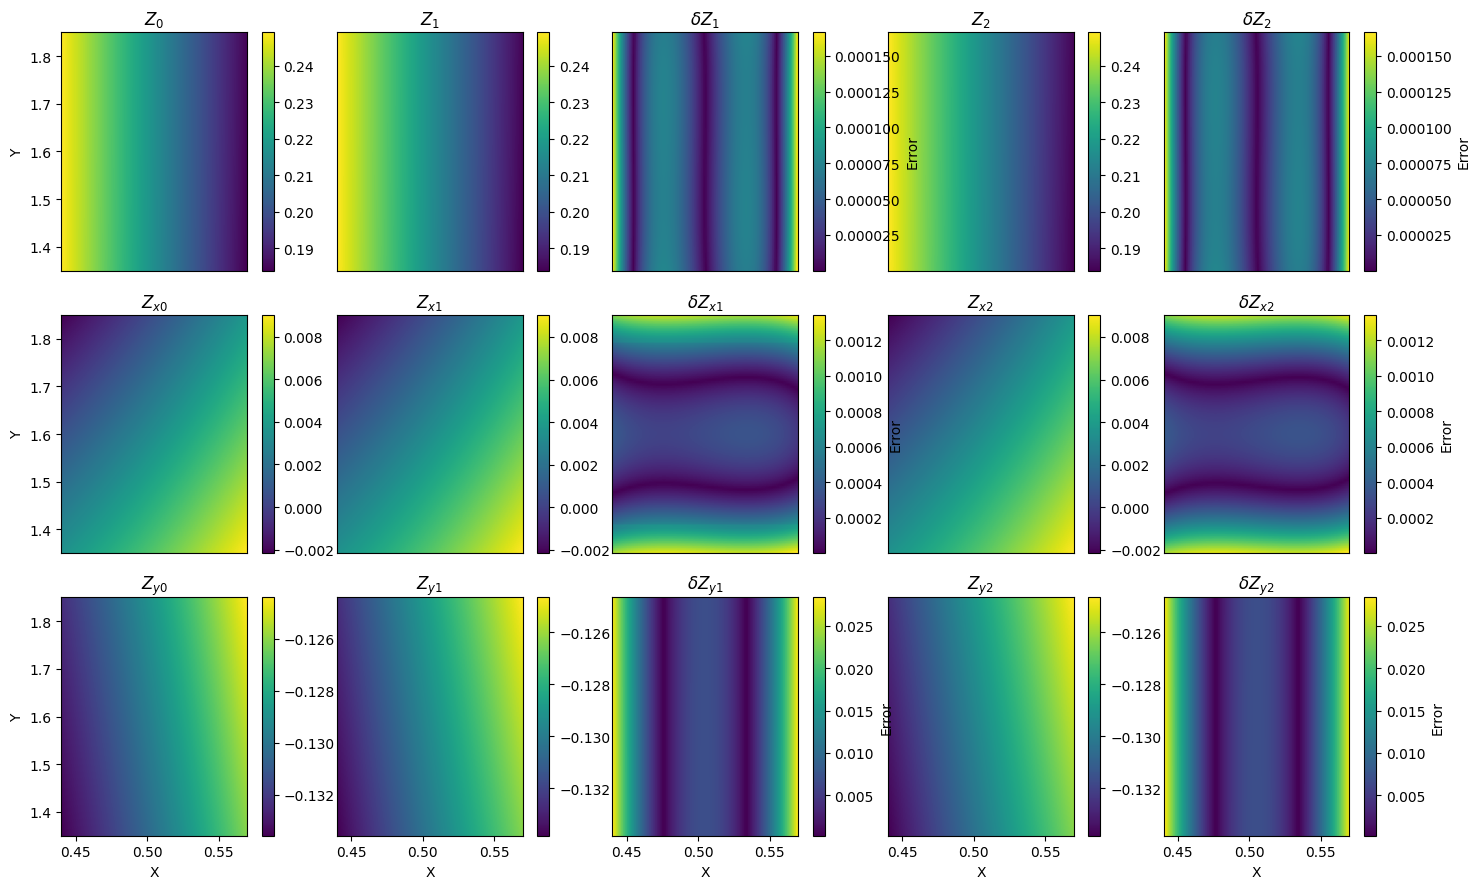

In [575]:
import numpy as np
import matplotlib.pyplot as plt

# Factor for adjusting the size of the figure
factor = 0.75

# Assuming you have defined x, y, z0, zx0, zy0, z1, zx1, zy1, z2, zx2, zy2, hy, hx, h, extent0 arrays/data

# Create figure and subplots
fig, axes = plt.subplots(3, 5, figsize=(20*factor, 12*factor))

# Define the extent
extent0 = [x.min(), x.max(), y.min(), y.max()]

# Plot data and colorbars
for i in range(3):
  for j in range(5):
    ax = axes[i, j]
    # Plot different images based on the subplot position
    if j == 0:
      if i == 0:
        im = ax.imshow(z0, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_0$'
      elif i == 1:
        im = ax.imshow(zx0, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{x0}$'
      else:
        im = ax.imshow(zy0, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{y0}$'
    elif j == 1:
      if i == 0:
        im = ax.imshow(z1, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_1$'
      elif i == 1:
        im = ax.imshow(zx1, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{x1}$'
      else:
        im = ax.imshow(zy1, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{y1}$'
    elif j == 2:
      if i == 0:
        im = ax.imshow(np.abs(z1 - z0) * h, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{1}$'
      elif i == 1:
        im = ax.imshow(np.abs(zx1 - zx0) * hx, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{x1}$'
      else:
        im = ax.imshow(np.abs(zy1 - zy0) * hy, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{y1}$'
    elif j == 3:
      if i == 0:
        im = ax.imshow(z2, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_2$'
      elif i == 1:
        im = ax.imshow(zx2, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{x2}$'
      else:
        im = ax.imshow(zy2, extent=extent0, origin='lower', cmap='viridis')
        title = '$Z_{y2}$'
    elif j == 4:
      if i == 0:
        im = ax.imshow(np.abs(z2 - z0) * h, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{2}$'
      elif i == 1:
        im = ax.imshow(np.abs(zx2 - zx0) * hx, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{x2}$'
      else:
        im = ax.imshow(np.abs(zy2 - zy0) * hy, extent=extent0, origin='lower', cmap='viridis')
        title = '$\delta Z_{y2}$'
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    if j == 2 or j == 4:
      cbar.set_label('Error')

    # Set title
    ax.set_title(title)

    # Set labels
    if i == 2:
      ax.set_xlabel('X')
    else:
      ax.set_xticks([])
      ax.set_xticklabels([])

    if j == 0:
      ax.set_ylabel('Y')
    else:
      ax.set_yticks([])
      ax.set_yticklabels([])

# Adjust layout to prevent overlap
plt.tight_layout()
#plt.subplots_adjust(right=0.75)

# Set aspect ratio for each subplot (4:3)
for ax in axes.flatten():
    ax.set_aspect(1/3)

# Show the plot
plt.show()